# Topic Modeling and Clustering of Laptop Reviews for Market Profiling

## INTRODUCTION
In today’s digital marketplace, customer reviews serve as a powerful lens into product perception, performance, and brand reputation. This project explores the application of natural language processing (NLP) techniques—specifically topic modeling and clustering—to analyze and interpret unstructured textual feedback on laptops. By extracting latent themes from customer reviews and grouping brands based on performance metrics and sentiment, this study aims to uncover actionable insights for market profiling. The analysis not only highlights what consumers value or criticize but also segments brands and products into meaningful clusters that reflect customer perception in real-world usage scenarios.

## Import essential libraries

In [ ]:
# Standard libraries
import re  # Regular expressions for text cleaning
import nltk  # Natural Language Toolkit for NLP tasks
import pandas as pd  # Data manipulation
import seaborn as sns  # Statistical data visualization
import matplotlib.pyplot as plt  # Plotting library

import warnings  # Manage warning messages
warnings.filterwarnings("ignore")  # Ignore warnings for clean output

import os  # Operating system interface
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Prevent parallel tokenizer deadlocks (HuggingFace)

# Text processing and visualization
from wordcloud import WordCloud  # Generate word clouds
from nltk.corpus import stopwords  # List of common stopwords
from nltk.stem import WordNetLemmatizer  # Lemmatization (word normalization)

# Feature extraction & topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text to TF-IDF matrix
from sklearn.decomposition import LatentDirichletAllocation  # LDA topic modeling

# Clustering and dimensionality reduction
from sklearn.preprocessing import StandardScaler  # Normalize features
from sklearn.cluster import KMeans  # KMeans clustering algorithm
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction

# BERTopic: advanced topic modeling using transformers
from bertopic import BERTopic  # BERTopic model
from sentence_transformers import SentenceTransformer  # Pretrained transformer-based sentence embeddings

# Download necessary NLTK datasets (only needs to run once)
nltk.download('stopwords')  # Download stopword list
nltk.download('wordnet')  # Download WordNet for lemmatization

## DATA PREPROCESSING

### Dataset Loading and Initial Cleaning

We load the dataset, convert numeric columns, clean text fields, extract brand names, and remove missing reviews to prepare the data for analysis.                                                                                                                          

In [5]:
# Load dataset from CSV file
df = pd.read_csv("laptops_dataset_final_600.csv")

# Make a clean working copy of the original DataFrame
df_clean = df.copy()

# Basic Cleaning

# Convert 'no_ratings' and 'no_reviews' columns from strings (with commas) to integers
df_clean['no_ratings'] = df_clean['no_ratings'].str.replace(',', '').astype(int)
df_clean['no_reviews'] = df_clean['no_reviews'].str.replace(',', '').astype(int)

# Convert 'review' and 'title' text to lowercase and remove leading/trailing whitespace
df_clean['review'] = df_clean['review'].str.lower().str.strip()
df_clean['title'] = df_clean['title'].str.lower().str.strip()

# Extract the brand name from the beginning of the 'product_name' string
df_clean['Brand'] = df_clean['product_name'].apply(
    lambda x: re.match(r'^\w+', x).group() if re.match(r'^\w+', x) else None
)

# Drop rows with missing reviews and reset the index
df_clean = df_clean.dropna(subset=['review']).reset_index(drop=True)

# Preview the cleaned data
df_clean.head()

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review,Brand
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,perfect product!,"loved it, it's my first macbook that i earned ...",Apple
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,fabulous!,battery lasted longer than my first relationsh...,Apple
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,fabulous!,such a great deal.. very happy with the perfor...,Apple
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,4,delightful,"awesome build quality and very good display, b...",Apple
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,awesome,when i ordered and came to know about seller r...,Apple


### Deriving Sentiment Categories from Review Ratings

We categorize each review into **Positive**, **Neutral**, or **Negative** sentiment based on its star rating:

- **4–5 stars** → **Positive**  
- **3 stars** → **Neutral**  
- **1–2 stars** → **Negative**


This **labeled sentiment column** will be used for **further analysis and visualization**, including comparisons across brands, topics, and review characteristics.

In [8]:
# Define a function to categorize sentiment based on star rating
def categorize_rating(r):
    if r >= 4:
        return "Positive"  # 4–5 stars → Positive sentiment
    elif r == 3:
        return "Neutral"   # 3 stars → Neutral sentiment
    else:
        return "Negative"  # 1–2 stars → Negative sentiment

# Apply the sentiment categorization to the 'rating' column
df_clean['sentiment'] = df_clean['rating'].apply(categorize_rating)

### Preparing Reviews for LDA: Tokenization, Lemmatization, and TF-IDF Transformation

We clean and preprocess the review text specifically for **LDA topic modeling** by:

- **Removing punctuation and numbers**  
- **Tokenizing and lemmatizing** words  
- **Removing stopwords** (e.g., *the*, *is*, *and*)


The processed text is then transformed into a **TF-IDF matrix**, which serves as input for the **LDA model** to extract underlying topics from the review corpus.

In [11]:
# LDA-Specific Preprocessing Pipeline

# Load English stopwords and initialize a lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess review text for LDA
def preprocess_for_lda(text):
    text = re.sub(r'[^\w\s]', '', text)         # Remove punctuation
    text = re.sub(r'\d+', '', text)             # Remove numbers
    tokens = text.split()                       # Tokenize text into words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(tokens)                     # Return the cleaned text as a single string

# Apply preprocessing to all reviews
df_clean['lda_cleaned_review'] = df_clean['review'].apply(preprocess_for_lda)

# Create TF-IDF matrix from the cleaned reviews
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')  # Configure vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['lda_cleaned_review'])    # Fit and transform the data

### BERTopic Pipeline: Text Preprocessing, Embedding Generation, and Topic Extraction

We clean the review text for BERTopic by removing punctuation and whitespace, then generate sentence embeddings using the all-MiniLM-L6-v2 model. These embeddings are clustered by BERTopic to extract semantically meaningful topics from customer reviews.

In [14]:
# BERTopic-Specific Preprocessing Pipeline

# Minimal preprocessing: remove punctuation and strip whitespace
def preprocess_for_bertopic(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()                  # Trim leading/trailing whitespace

# Apply BERTopic preprocessing to the review column
df_clean['bertopic_cleaned_review'] = df_clean['review'].apply(preprocess_for_bertopic)

# Load the SentenceTransformer model for embedding the reviews
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize BERTopic with the specified embedding model
bertopic_model = BERTopic(embedding_model=embedding_model)

# Fit the BERTopic model and generate topics with their probabilities
topics, probs = bertopic_model.fit_transform(df_clean['bertopic_cleaned_review'])

### Preview of Cleaned Dataset

In [17]:
# Preview the cleaned DataFrame after preprocessing
df_clean.head()

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review,Brand,sentiment,lda_cleaned_review,bertopic_cleaned_review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,perfect product!,"loved it, it's my first macbook that i earned ...",Apple,Positive,loved first macbook earned hardwork,loved it its my first macbook that i earned fr...
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,fabulous!,battery lasted longer than my first relationsh...,Apple,Positive,battery lasted longer first relationship day l...,battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,fabulous!,such a great deal.. very happy with the perfor...,Apple,Positive,great deal happy performance battery lifeorigi...,such a great deal very happy with the performa...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,4,delightful,"awesome build quality and very good display, b...",Apple,Positive,awesome build quality good display battery cam...,awesome build quality and very good display ba...
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,awesome,when i ordered and came to know about seller r...,Apple,Positive,ordered came know seller reviewi scared condit...,when i ordered and came to know about seller r...


## EXPLORATORY DATA ANALYSIS

The goal of this exploratory analysis is to uncover key patterns in customer feedback across various laptop products and brands. By analyzing review ratings, sentiment categories, and textual content, we aim to understand which factors contribute to positive or negative customer experiences.

### Key Questions:

Q1. How do customer ratings, review volume, sentiment, and brand interact?
We explore rating distributions, most-reviewed laptops, and how different brands perform in terms of customer satisfaction. This helps us understand general product reception and brand reputation in the market.

Q2. Which features reflect product quality and influence customer satisfaction?
We investigate review length, star ratings, and sentiment categories. Word clouds and sentiment distribution visualizations further help us discover what customers highlight in their feedback — such as performance, battery life, or display issues.

### Focus of Analysis:

In this project, the main objective is to understand **product perception** and **brand performance**, as captured through:

- **Review Ratings** (1–5 stars)  
- **Sentiment Categories** (Positive, Neutral, Negative)  
- **Review Length** (word count)


We assess how these are influenced by:

- **Brand Identity**  
  Manufacturer-level performance across metrics.

- **Textual Review Patterns**  
  Common themes and keywords extracted via word clouds and NLP techniques.

- **Volume and Variability**  
  Total number of reviews and rating consistency across products.


These insights lay the groundwork for **deeper topic modeling**, **brand clustering**, and **performance profiling** across the laptop market.

---

### Distribution of Review Ratings

We begin by analyzing how ratings are distributed across the dataset to understand the general tone of customer sentiment.

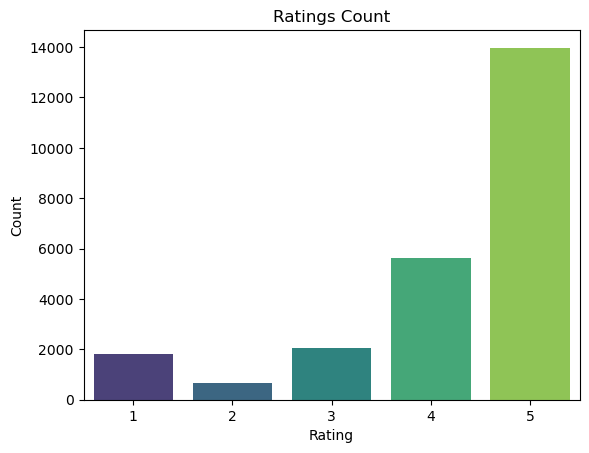

In [27]:
# Plot the distribution of ratings using Seaborn's countplot
sns.countplot(x="rating", data=df_clean, palette="viridis")

# Set plot title and axis labels
plt.title("Ratings Count")
plt.xlabel("Rating")
plt.ylabel("Count")

# Display the plot
plt.show()

### Top 10 Laptops by Average Overall Rating

This shows which products customers rate highest on average across all reviews.

In [31]:
# Calculate the average overall rating per product
# Sort the products in descending order to get the top-rated ones
# Display the top 10 products with the highest average rating
df_clean.groupby("product_name")["overall_rating"].mean().sort_values(ascending=False).head(10)

product_name
ASUS ProArt PX13 OLED (2024) - AI PC for Creator, AMD Ryzen AI...    5.0
ASUS AMD Ryzen 5 Quad Core - (16 GB/512 GB SSD/Windows 11 Home...    4.8
HP ENVY AI PC Intel Core Ultra 5 125U - (16 GB/512 GB SSD/Wind...    4.8
Lenovo Legion Go AMD Ryzen Z1 Extreme - (16 GB/512 GB SSD/Wind...    4.8
GIGABYTE G Series Intel Core i5 12th Gen 12500H - (16 GB/512 G...    4.7
ASUS Vivobook S 15 OLED Powered, Intel EVO H Series, AI PC Int...    4.7
MSI Cyborg 15 Intel Core i7 12th Gen 12650H - (16 GB/512 GB SS...    4.7
Apple MacBook AIR Apple M2 - (8 GB/512 GB SSD/Mac OS Monterey)...    4.7
Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/Mac OS Monterey)...    4.7
DELL AMD Ryzen 5 Dual Core 7520U - (8 GB/512 GB SSD/Windows 11...    4.7
Name: overall_rating, dtype: float64

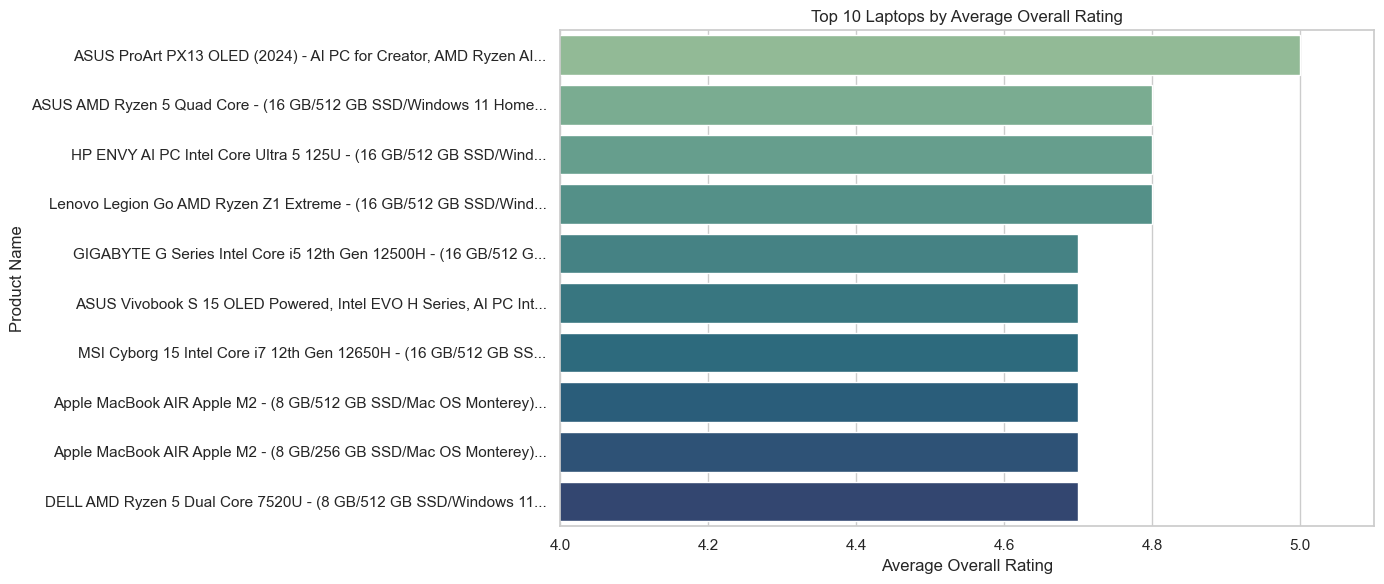

In [33]:
# Set seaborn plot style for a clean grid layout
sns.set(style="whitegrid")

# Compute the top 10 laptops by average overall rating
top_rated = (
    df_clean.groupby("product_name")["overall_rating"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Create a horizontal bar plot of top-rated laptops
plt.figure(figsize=(14, 6))
sns.barplot(x=top_rated.values, y=top_rated.index, palette="crest")

# Set plot title and labels
plt.title("Top 10 Laptops by Average Overall Rating")
plt.xlabel("Average Overall Rating")
plt.ylabel("Product Name")

# Set x-axis limits for better visual range
plt.xlim(4.0, 5.1)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

### Top 10 Most Reviewed Laptops

Most-reviewed laptops often indicate popularity or strong brand presence.

In [37]:
# Group by product name and get the maximum number of reviews for each product
# Sort the products in descending order based on number of reviews
# Display the top 10 products with the highest review count
df_clean.groupby("product_name")["no_reviews"].max().sort_values(ascending=False).head(10)

product_name
realme Book (Slim) Intel Core i3 11th Gen 1115G4 - (8 GB/256 G...    2171
HP 14s Intel Core i3 11th Gen 1115G4 - (8 GB/512 GB SSD/Window...     954
Acer One Intel Core i3 11th Gen 1115G4 - (8 GB/512 GB SSD/Wind...     906
Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/Mac OS Monterey)...     900
Apple MacBook AIR Apple M2 - (8 GB/512 GB SSD/Mac OS Monterey)...     900
Primebook 4G Android Based MediaTek MT8788 - (4 GB/64 GB EMMC ...     861
ASUS Vivobook 15 Intel Core i3 11th Gen 1115G4 - (16 GB/512 GB...     758
Primebook Wifi MediaTek MT8183 - (4 GB/64 GB EMMC Storage/Prim...     725
ASUS Vivobook 15, with Backlit Keyboard, Intel Core i3 12th Ge...     698
ASUS Vivobook 15 Intel Core i3 12th Gen 1215U - (8 GB/512 GB S...     698
Name: no_reviews, dtype: int64

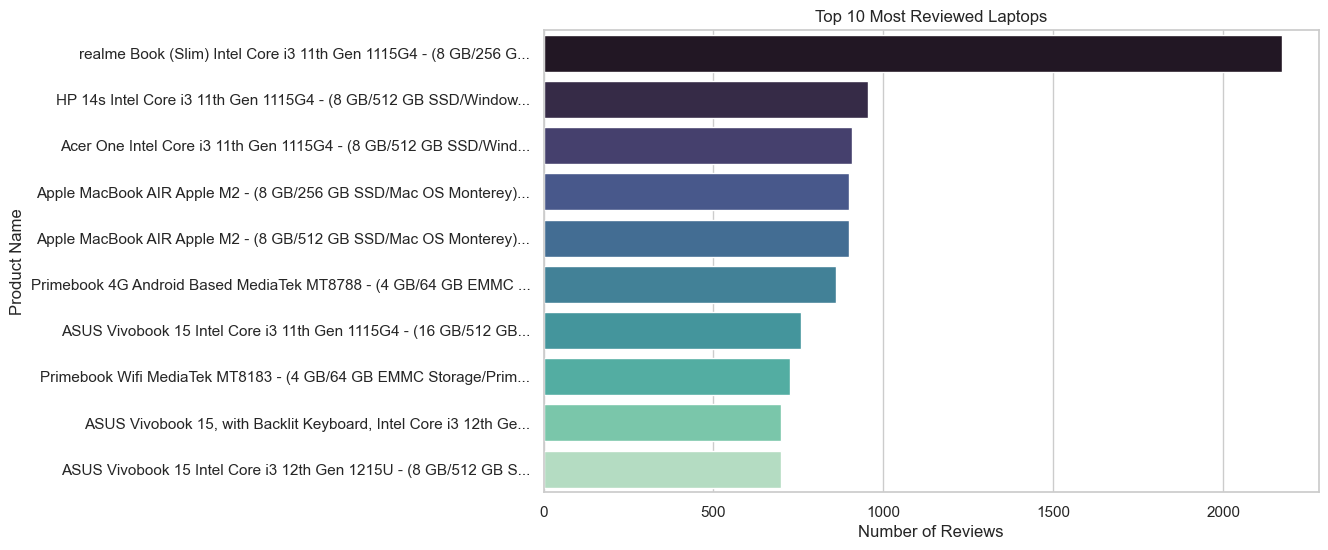

In [39]:
# Top 10 Laptops by Number of Reviews

# Group by product name and get the maximum number of reviews per product
most_reviewed = (
    df_clean.groupby("product_name")["no_reviews"]
    .max()
    .sort_values(ascending=False)
    .head(10)
)

# Create a horizontal bar plot to visualize the most reviewed laptops
plt.figure(figsize=(10, 6))
sns.barplot(x=most_reviewed.values, y=most_reviewed.index, palette="mako")

# Add plot title and axis labels
plt.title("Top 10 Most Reviewed Laptops")
plt.xlabel("Number of Reviews")
plt.ylabel("Product Name")

# Display the plot
plt.show()

### Correlation Between Review Count and Rating

This scatter plot explores whether high review volume correlates with high (or low) overall rating.

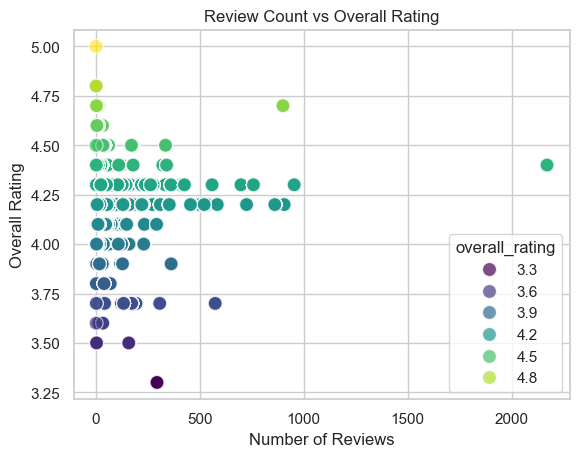

In [43]:
# Scatter plot: Number of Reviews vs Overall Rating
sns.scatterplot(
    x="no_reviews",             # X-axis: number of reviews
    y="overall_rating",         # Y-axis: overall rating
    data=df_clean,              # Data source
    hue="overall_rating",       # Color points by rating
    palette="viridis",          # Colormap
    alpha=0.7,                  # Point transparency
    s=100                       # Point size
)

# Set plot title and axis labels
plt.title("Review Count vs Overall Rating")
plt.xlabel("Number of Reviews")
plt.ylabel("Overall Rating")

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()

### Word Clouds by Sentiment

We generate word clouds from positive, neutral, and negative reviews to discover common terms and topics in each sentiment group.

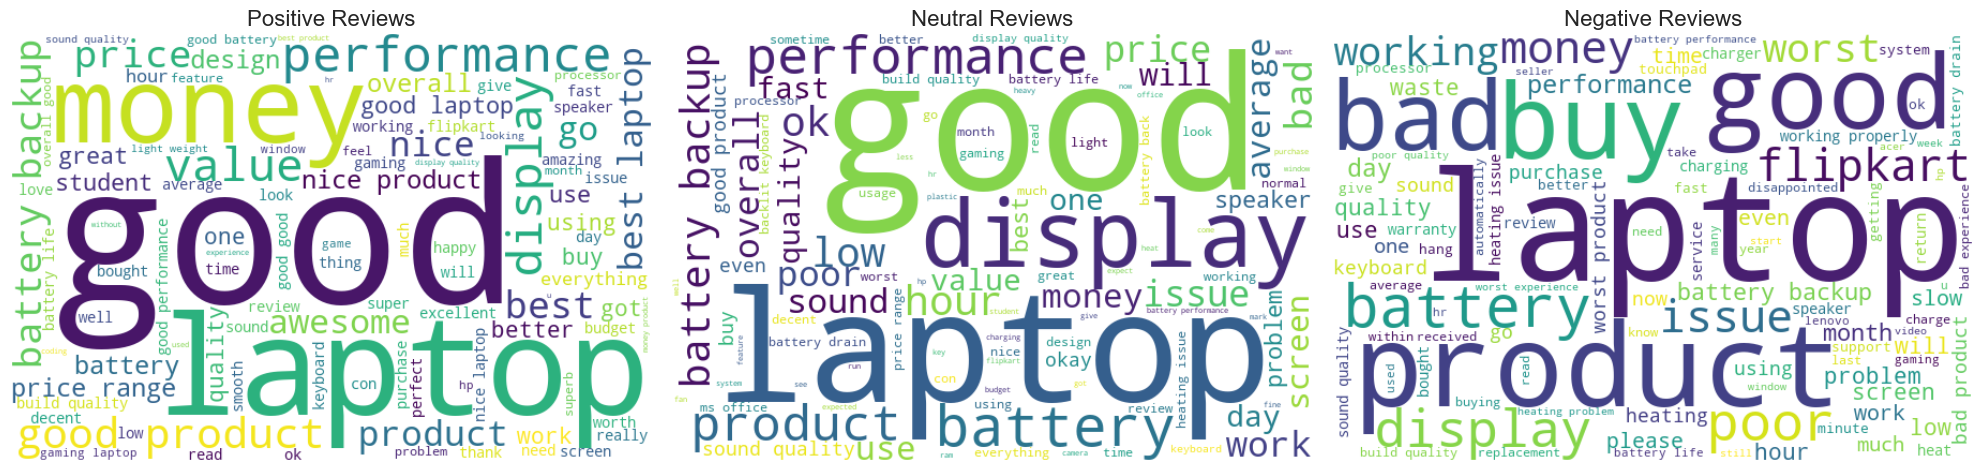

In [47]:
# Generate Word Clouds by Sentiment

# Combine all reviews for each sentiment into a single string
positive_text = " ".join(df_clean[df_clean['sentiment'] == "Positive"]['review'])
neutral_text = " ".join(df_clean[df_clean['sentiment'] == "Neutral"]['review'])
negative_text = " ".join(df_clean[df_clean['sentiment'] == "Negative"]['review'])

# Set up subplots for side-by-side word clouds
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Generate and display a word cloud for each sentiment category
for ax, text, title in zip(axes,
                           [positive_text, neutral_text, negative_text],
                           ["Positive Reviews", "Neutral Reviews", "Negative Reviews"]):
    wordcloud = WordCloud(
        width=600,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')  # Render word cloud
    ax.set_title(title, fontsize=16)                # Add title to subplot
    ax.axis('off')                                  # Hide axes

# Adjust layout to prevent overlap
plt.tight_layout()

# Display all three word clouds
plt.show()

### Top-Rated Products for a Specific Brand (Dell)

We can drill down to specific brands to examine their top-rated models.

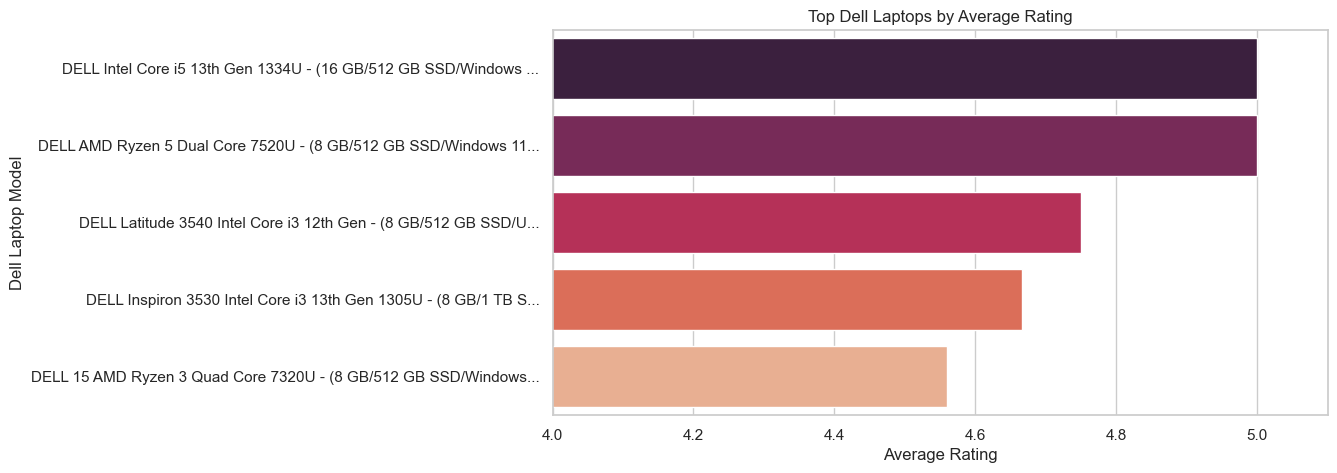

In [51]:
# Filter & Visualize Top Dell Laptops by Rating

# Filter rows where the product name contains "dell" (case-insensitive)
dell_df = df_clean[df_clean['product_name'].str.contains("dell", case=False)]

# Group by product name, calculate average rating, and get top 5 models
top_dell_models = (
    dell_df.groupby("product_name")["rating"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Plot the top-rated Dell laptops
plt.figure(figsize=(10, 5))
sns.barplot(x=top_dell_models.values, y=top_dell_models.index, palette="rocket")

# Set plot title and labels
plt.title("Top Dell Laptops by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Dell Laptop Model")
plt.xlim(4.0, 5.1)

# Show the plot
plt.show()

### Review Length by Sentiment

Do people write more when they love or hate a product? This boxplot shows the average length of reviews across sentiment categories.

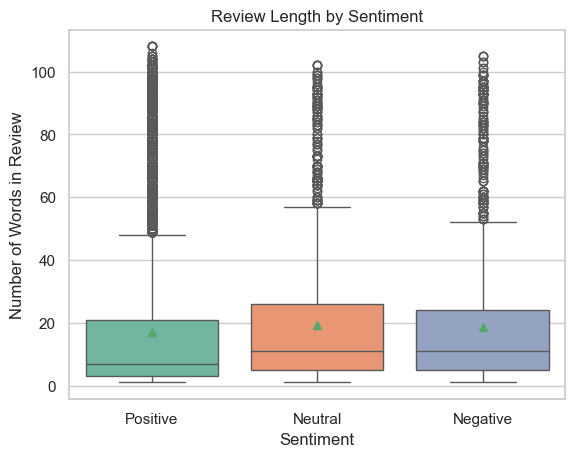

In [55]:
# Create a new column to store the number of words in each review
df_clean['review_length'] = df_clean['review'].apply(lambda x: len(x.split()))

# Plot a boxplot to show distribution of review lengths across sentiment categories
sns.boxplot(
    x='sentiment',
    y='review_length',
    data=df_clean,
    palette='Set2',     # Use a soft color palette
    showmeans=True      # Display mean as a green triangle
)

# Add plot title and axis labels
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words in Review")

# Display the plot
plt.show()

### Sentiment Distribution by Brand

This shows how each brand performs in terms of positive, neutral, and negative feedback proportions.

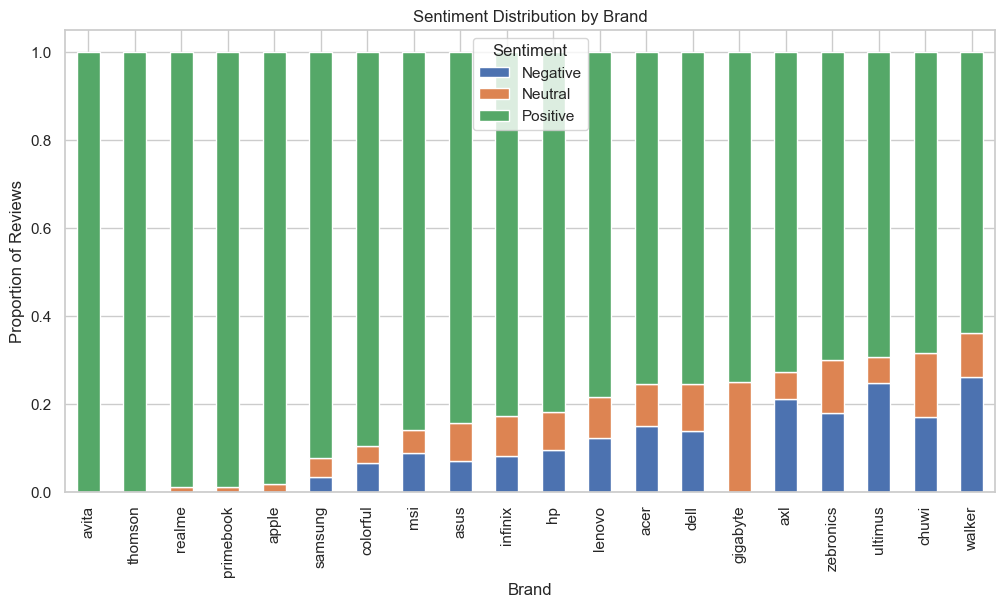

In [59]:
# Extract the brand name from the product_name (first word, lowercase)
df_clean['brand'] = df_clean['product_name'].apply(lambda x: x.split()[0].lower())

# Group by brand and sentiment, count occurrences, and reshape into a wide format
brand_sentiment = df_clean.groupby(['brand', 'sentiment']).size().unstack().fillna(0)

# Convert counts to percentages (row-wise normalization)
brand_sentiment_pct = brand_sentiment.div(brand_sentiment.sum(axis=1), axis=0)

# Sort brands by proportion of positive sentiment, descending
brand_sentiment_pct.sort_values('Positive', ascending=False).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)

# Add plot title and axis labels
plt.title("Sentiment Distribution by Brand")
plt.ylabel("Proportion of Reviews")
plt.xlabel("Brand")

# Show legend for sentiment categories
plt.legend(title="Sentiment")

# Display the plot
plt.show()

### Rating vs Review Length

This plot tests whether longer reviews are tied to higher (or lower) ratings.

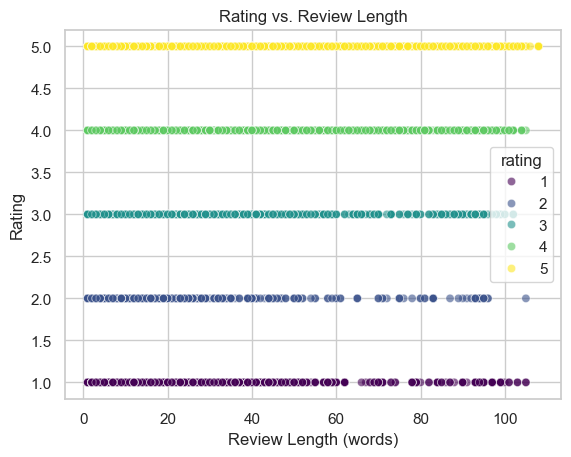

In [63]:
# Scatter plot to explore the relationship between review length and rating
sns.scatterplot(
    data=df_clean,
    x='review_length',      # X-axis: number of words in the review
    y='rating',             # Y-axis: rating given by the user
    hue='rating',           # Color points by rating value
    palette='viridis',      # Use a perceptually uniform color palette
    alpha=0.6               # Semi-transparent points for better visibility
)

# Set plot title and axis labels
plt.title("Rating vs. Review Length")
plt.xlabel("Review Length (words)")
plt.ylabel("Rating")

# Show the plot
plt.show()

## TOPIC MODELING

### LDA Topic Modeling

In this section, we apply Latent Dirichlet Allocation (LDA) to uncover hidden topics within customer reviews. After cleaning the text and transforming it into a TF-IDF matrix, we train the LDA model to discover latent themes that commonly appear in user feedback. These topics help us understand what customers typically focus on — such as battery life, performance, display quality, or delivery experience.

---

### Fitting the LDA Model

We initialize and fit an LDA model with 5 topics using the TF-IDF matrix derived from cleaned review text. Each topic is modeled as a distribution over words, and each review is modeled as a mixture of those topics. This allows us to capture the main themes customers discuss in their feedback.

In [70]:
# Fit LDA Topic Model

# Initialize the LDA model with 5 topics and a fixed random state for reproducibility
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)

# Fit the LDA model to the TF-IDF matrix generated from cleaned review text
lda_model.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

### Interpreting LDA Topics: Top Keywords per Theme

After training the LDA model, we extract the top keywords for each topic. These keywords represent the most influential terms that define the underlying themes in customer reviews. By analyzing these keywords, we can label and understand what each topic represents — such as product quality, battery performance, delivery service, or user satisfaction.

In [74]:
# Display Top Words for Each LDA Topic

# Define a function to print the top N words for each topic
def print_lda_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()  # Get vocabulary terms from the TF-IDF vectorizer
    for idx, topic in enumerate(model.components_):  # Loop through each topic
        print(f"\nTopic {idx}:")  # Print topic index
        # Print the top N words (highest-weighted) for the topic
        print([words[i] for i in topic.argsort()[-top_n:]])

# Call the function to display the top 10 words per topic
print_lda_topics(lda_model, tfidf_vectorizer)


Topic 0:
['flipkart', 'worth', 'great', 'bad', 'laptop', 'amazing', 'ok', 'super', 'product', 'nice']

Topic 1:
['display', 'poor', 'quality', 'laptop', 'battery', 'performance', 'value', 'money', 'product', 'good']

Topic 2:
['gb', 'flipkart', 'good', 'fine', 'working', 'performance', 'product', 'laptop', 'love', 'excellent']

Topic 3:
['hour', 'gaming', 'day', 'performance', 'student', 'work', 'use', 'battery', 'good', 'laptop']

Topic 4:
['quality', 'battery', 'performance', 'product', 'range', 'good', 'awesome', 'price', 'laptop', 'best']


### Assigning Dominant Topics to Reviews

Once the LDA model is trained, we compute the topic distribution for each review and assign the most dominant topic to it. This helps classify each review under a specific theme based on its content, enabling further analysis such as sentiment by topic or topic frequency distribution.

In [78]:
# Assign Dominant LDA Topic to Each Review

# Get the topic distribution for each review (document)
topic_distribution = lda_model.transform(tfidf_matrix)

# Assign the topic with the highest probability as the dominant topic
df_clean['lda_topic'] = topic_distribution.argmax(axis=1)

### Naming LDA Topics for Interpretability

In [81]:
# Map LDA Topic Numbers to Descriptive Labels

# Dictionary mapping LDA topic indices to descriptive topic names
topic_names = {
    0: "General Sentiment (Flipkart & Quality)",
    1: "Display & Performance Issues",
    2: "Good Performance & Experience",
    3: "Gaming & Battery Life",
    4: "High-Quality & Value Products"
}

# Create a new column with the mapped topic names
df_clean['lda_topic_name'] = df_clean['lda_topic'].map(topic_names)

### Preview of Dataset with LDA Topic Assignments

We now display the first few rows of the updated dataset, which includes the original review content, the cleaned review for LDA, and the assigned dominant topic for each review. This allows us to verify that the topic modeling step successfully enriched the dataset with thematic information.

In [85]:
df_clean.head()

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review,Brand,sentiment,lda_cleaned_review,bertopic_cleaned_review,review_length,brand,lda_topic,lda_topic_name
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,perfect product!,"loved it, it's my first macbook that i earned ...",Apple,Positive,loved first macbook earned hardwork,loved it its my first macbook that i earned fr...,13,apple,1,Display & Performance Issues
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,fabulous!,battery lasted longer than my first relationsh...,Apple,Positive,battery lasted longer first relationship day l...,battery lasted longer than my first relationsh...,58,apple,1,Display & Performance Issues
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,fabulous!,such a great deal.. very happy with the perfor...,Apple,Positive,great deal happy performance battery lifeorigi...,such a great deal very happy with the performa...,16,apple,4,High-Quality & Value Products
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,4,delightful,"awesome build quality and very good display, b...",Apple,Positive,awesome build quality good display battery cam...,awesome build quality and very good display ba...,14,apple,4,High-Quality & Value Products
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,awesome,when i ordered and came to know about seller r...,Apple,Positive,ordered came know seller reviewi scared condit...,when i ordered and came to know about seller r...,90,apple,2,Good Performance & Experience


### Distribution of Reviews Across LDA Topics

This bar plot illustrates how many reviews were assigned to each LDA-derived topic. By analyzing the frequency of topics, we gain insights into which themes are most commonly discussed by customers. This can highlight common concerns or frequently praised product features.

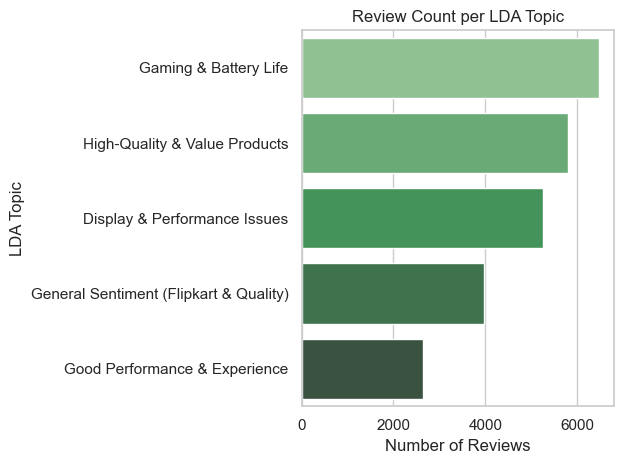

In [89]:
# Plot Review Count per LDA Topic

# Count the number of reviews assigned to each LDA topic name
topic_counts = df_clean['lda_topic_name'].value_counts()

# Create a horizontal bar plot of topic frequencies
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="Greens_d")

# Add plot title and axis labels
plt.title("Review Count per LDA Topic")
plt.xlabel("Number of Reviews")
plt.ylabel("LDA Topic")

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

### Average Rating by LDA Topic

This chart shows the average customer rating for each topic identified by the LDA model. It helps us understand which themes are associated with more positive or negative feedback. For example, topics focused on quality and value may have higher ratings, while those related to performance issues may receive lower scores.

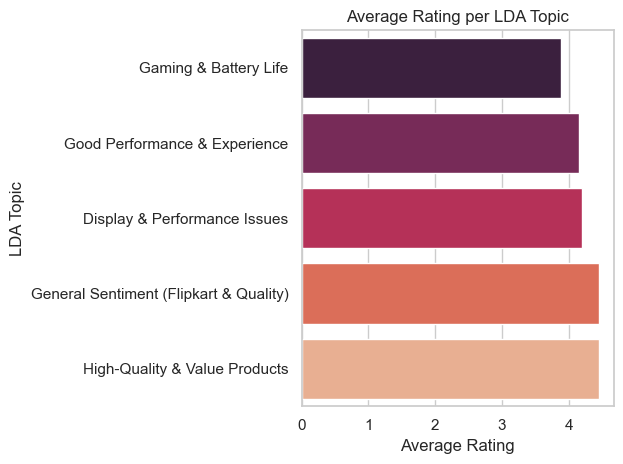

In [92]:
# Plot Average Rating per LDA Topic

# Group the data by LDA topic name and calculate the mean rating for each topic
avg_rating_by_topic = df_clean.groupby('lda_topic_name')['rating'].mean().sort_values()

# Create a horizontal bar plot to visualize average rating per topic
sns.barplot(x=avg_rating_by_topic.values, y=avg_rating_by_topic.index, palette="rocket")

# Add title and axis labels
plt.title("Average Rating per LDA Topic")
plt.xlabel("Average Rating")
plt.ylabel("LDA Topic")

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

###  Results and Interpretation of LDA Topics

After applying LDA topic modeling, we identified five dominant themes across customer laptop reviews. Each review was assigned to one of these topics based on its textual content. The frequency and average rating of reviews within each topic provide key insights into what customers talk about most — and how positively they feel about those themes.

### Topic Distribution Insights

- **Gaming & Battery Life**  
  Received the highest number of reviews, indicating that performance and battery are commonly discussed aspects—especially among users focused on gaming and longer usage.

- **High-Quality & Value Products**  
  Appeared frequently, suggesting strong customer interest in perceived quality and whether the product meets value expectations.

- **Display & Performance Issues**  
  Also had a notable presence, pointing to common technical concerns raised by customers.

- **General Sentiment (Flipkart & Quality)**  
  Fewer mentions, but still capture key perceptions about the platform and overall product reliability.

- **Good Performance & Experience**  
  Represented a smaller, but still meaningful portion of the discussions, focusing on positive usage experiences.

This distribution highlights that **technical performance** and **value-for-money** are dominant areas of concern or appreciation in customer reviews.

### Average Rating by Topic Insights

- **High-Quality & Value Products**  
  Received the highest average rating, implying strong customer satisfaction for laptops perceived as premium or offering good value.

- **General Sentiment** and **Display & Performance Issues**  
  Had lower average ratings, suggesting that users associate these topics with mixed or negative experiences.

- **Gaming & Battery Life**  
  Despite being the most discussed topic, also had strong average ratings — reflecting customer satisfaction with high-performance laptops.

### Interpretation Summary

- **Performance-Related Topics Dominate**  
  Most discussions revolve around product performance, gaming ability, and battery life — a clear reflection of user priorities.

- **Customer Satisfaction Peaks with Perceived Value**  
  Products seen as delivering quality and value tend to get the highest ratings.

- **Room for Improvement**  
  Topics involving display issues or general complaints about platform experience (e.g., Flipkart logistics or packaging) tend to bring ratings down.

---

### BERTopic Modeling

In this section, we implement BERTopic, a state-of-the-art NLP technique that combines transformer-based sentence embeddings with density-based clustering to uncover coherent and context-rich topics from customer reviews. Unlike traditional models such as LDA, BERTopic captures the semantic meaning of text, allowing for more nuanced and accurate topic discovery.

We utilize the all-MiniLM-L6-v2 embedding model to represent each review in high-dimensional space. These embeddings are then clustered to group similar reviews, and the most representative keywords for each cluster are extracted to describe the underlying topics. This technique enables us to identify the dominant themes in customer sentiment and provides deeper insight into product strengths, pain points, and brand perception.

### Assigning BERTopic Labels and Probabilities to Reviews

Once the BERTopic model is trained, we assign the generated topic and its associated confidence score (probability) to each review. The bertopic_topic column stores the most likely topic for a given review, while bertopic_prob indicates the model’s confidence in that assignment. These assignments allow for further analysis of topic frequency, sentiment distribution across topics, and brand-specific topic trends.

In [94]:
# Assign BERTopic Results to DataFrame

# Store the topic number assigned by BERTopic for each review
df_clean['bertopic_topic'] = topics

# Store the corresponding topic probability (confidence score)
df_clean['bertopic_prob'] = probs

### Summary of Extracted BERTopic Topics

After training the BERTopic model, we retrieve a summary of the discovered topics using get_topic_info(). This summary provides an overview of each topic, including its frequency (i.e., number of reviews assigned) and the top representative keywords. It helps us evaluate the relevance and clarity of each topic and identify which themes are most commonly discussed by customers.

In [96]:
# Get Summary Information from BERTopic Model

# Retrieve metadata for all topics including:
# - Topic number
# - Topic name (keywords)
# - Number of documents assigned to each topic
topic_info = bertopic_model.get_topic_info()

# Display the first few rows of the topic summary
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4335,-1_gaming_you_it_and,"[gaming, you, it, and, more, to, display, game...",[everything is nice except two things\n1 displ...
1,0,985,0_good_po_yes_enough,"[good, po, yes, enough, ok, okay, , , , ]","[good, good, good]"
2,1,472,1_product_good_verry_okay,"[product, good, verry, okay, ok, perfect, type...","[good product, good product, good product]"
3,2,373,2_nice_niceee_baitry_wow,"[nice, niceee, baitry, wow, itam, 23, hour, on...","[nice, nice, nice]"
4,3,341,3_nice_product_productloved_protect,"[nice, product, productloved, protect, niceee,...","[nice product, nice product, nice product]"


### Interpreting and Naming BERTopic Topics

To improve interpretability, we review the top keywords for each of the top 5 BERTopic topics and manually assign intuitive labels. These labels reflect the core themes emerging from customer feedback — such as praise for performance, concerns about battery life, or issues with delivery services. Assigning human-readable names helps bridge the gap between machine-generated clusters and actionable business insights.

In [98]:
# Inspect Top Keywords for BERTopic Topics

# Loop through first 5 topics and print their top keywords
for i in range(5):  # Adjust range if you have more topics
    print(f"Topic {i}:")
    print(bertopic_model.get_topic(i))  # Returns a list of (keyword, weight) tuples
    print()

# Map BERTopic Topic Numbers to Descriptive Labels

# Dictionary of manually assigned topic names based on keyword inspection
bertopic_topic_names = {
    0: "General Quality & Experience",
    1: "Battery & Heating Issues",
    2: "Performance Praise",
    3: "Screen/Display Feedback",
    4: "Delivery/Flipkart Service"
}

# Create a new column in the DataFrame for descriptive topic names
df_clean['bertopic_topic_name'] = df_clean['bertopic_topic'].map(bertopic_topic_names)

Topic 0:
[('good', 0.04690212735988098), ('po', 0.006439379472211391), ('yes', 0.004533261021369065), ('enough', 0.0036166626832669084), ('ok', 0.0035483992031894018), ('okay', 0.0015074663312071867), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]

Topic 1:
[('product', 0.043633641089860536), ('good', 0.02318681875014347), ('verry', 0.0067455398876797865), ('okay', 0.0031604593176830635), ('ok', 0.003099729629228937), ('perfect', 0.0028090460751119856), ('type', 0.0015020092302207347), ('device', 0.0014213490690506928), ('buy', 0.0004018089701762079), ('can', 0.0003766706912348347)]

Topic 2:
[('nice', 0.17938474308408936), ('niceee', 0.03895725415385484), ('baitry', 0.02597150276923656), ('wow', 0.017841061591631898), ('itam', 0.01475938133220439), ('23', 0.01093769153711545), ('hour', 0.006981956734997629), ('only', 0.0016657259595269699), ('but', 0.0006999522589327116), ('to', 0.0003015815698090095)]

Topic 3:
[('nice', 0.09121304878821138), ('product', 0.042447764557777365), (

### Preview of Dataset with BERTopic Assignments

In [100]:
df_clean.head()

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review,Brand,sentiment,lda_cleaned_review,bertopic_cleaned_review,review_length,brand,lda_topic,lda_topic_name,bertopic_topic,bertopic_prob,bertopic_topic_name
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,perfect product!,"loved it, it's my first macbook that i earned ...",Apple,Positive,loved first macbook earned hardwork,loved it its my first macbook that i earned fr...,13,apple,1,Display & Performance Issues,442,0.777543,NaN
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,fabulous!,battery lasted longer than my first relationsh...,Apple,Positive,battery lasted longer first relationship day l...,battery lasted longer than my first relationsh...,58,apple,1,Display & Performance Issues,391,0.999990,NaN
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,fabulous!,such a great deal.. very happy with the perfor...,Apple,Positive,great deal happy performance battery lifeorigi...,such a great deal very happy with the performa...,16,apple,4,High-Quality & Value Products,224,0.000084,NaN
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,4,delightful,"awesome build quality and very good display, b...",Apple,Positive,awesome build quality good display battery cam...,awesome build quality and very good display ba...,14,apple,4,High-Quality & Value Products,-1,0.000000,NaN
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,awesome,when i ordered and came to know about seller r...,Apple,Positive,ordered came know seller reviewi scared condit...,when i ordered and came to know about seller r...,90,apple,2,Good Performance & Experience,400,0.500037,NaN


### BERTopic Topic Distribution

This bar chart shows the number of reviews associated with each BERTopic topic after filtering out noise (-1 topics). It provides insight into which themes are most frequently mentioned by customers. For instance, if topics like “Battery & Heating Issues” appear frequently, it may indicate common pain points, whereas a high count under “Performance Praise” suggests widespread satisfaction.

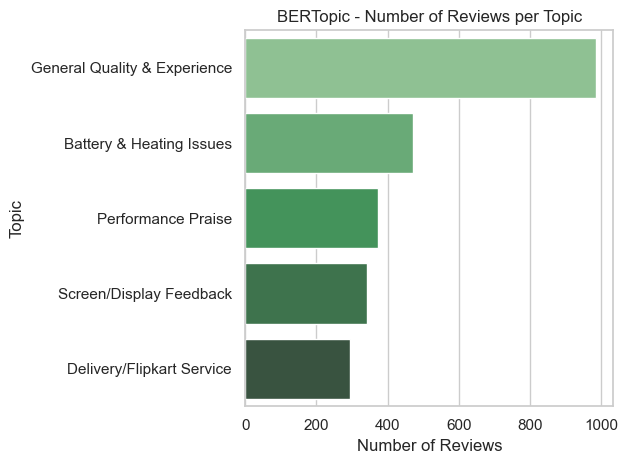

In [104]:
# Filter Out Reviews with Valid BERTopic Assignments

# Exclude rows where topic name is missing (i.e., topic -1 or unmapped)
bertopic_valid = df_clean[df_clean['bertopic_topic_name'].notnull()]

# Count the number of reviews per BERTopic topic name
topic_counts = bertopic_valid['bertopic_topic_name'].value_counts()

# Plot Number of Reviews per BERTopic Topic

# Create a horizontal bar chart to show topic distribution
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="Greens_d")

# Add plot title and labels
plt.title("BERTopic - Number of Reviews per Topic")
plt.xlabel("Number of Reviews")
plt.ylabel("Topic")

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

### Average Rating by BERTopic Topic

This bar chart displays the average customer rating associated with each BERTopic-labeled theme. It helps us understand how different topics correlate with user satisfaction. For example, topics related to Performance Praise or General Quality tend to receive higher ratings, while topics like Battery & Heating Issues may align with lower satisfaction scores. This analysis provides a deeper look at which aspects of the customer experience drive positive or negative perceptions.

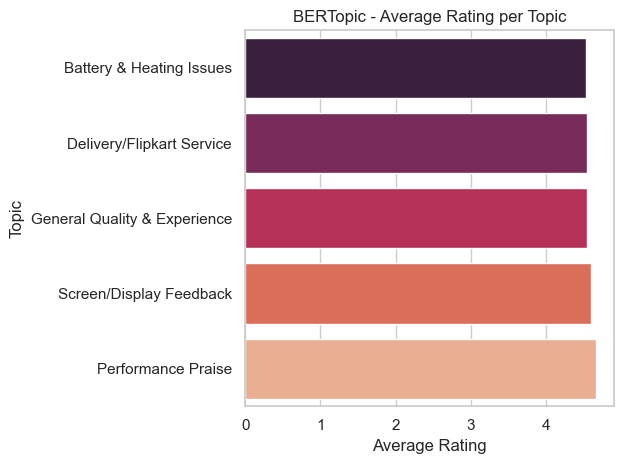

In [106]:
# Calculate Average Rating for Each BERTopic Topic

# Group by topic name and compute average rating
avg_rating_bertopic = (
    bertopic_valid
    .groupby('bertopic_topic_name')['rating']
    .mean()
    .sort_values()
)

# Plot Average Rating per BERTopic Topic

# Create a horizontal bar plot of average ratings
sns.barplot(x=avg_rating_bertopic.values, y=avg_rating_bertopic.index, palette="rocket")

# Add plot title and axis labels
plt.title("BERTopic - Average Rating per Topic")
plt.xlabel("Average Rating")
plt.ylabel("Topic")

# Improve layout spacing
plt.tight_layout()

# Display the plot
plt.show()

### Average Review Length by BERTopic Topic

This visualization shows the average number of words per review across each BERTopic topic. Longer reviews often indicate more detailed feedback — which can suggest stronger emotional responses, whether positive or negative. For instance, topics like Delivery/Flipkart Service or Battery & Heating Issues may prompt users to elaborate more due to frustration, while Performance Praise might result in concise, positive remarks. Analyzing review length provides additional context to the sentiment and importance of each theme.

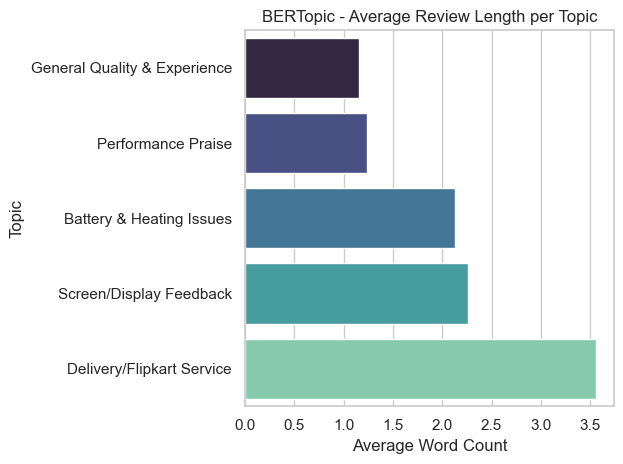

In [108]:
# Calculate Average Review Length for Each BERTopic Topic

# Group by topic name and compute average word count per review
avg_len_bertopic = (
    bertopic_valid
    .groupby('bertopic_topic_name')['review_length']
    .mean()
    .sort_values()
)

# Plot Average Review Length per BERTopic Topic

# Create a horizontal bar plot of average review length by topic
sns.barplot(x=avg_len_bertopic.values, y=avg_len_bertopic.index, palette="mako")

# Add plot title and axis labels
plt.title("BERTopic - Average Review Length per Topic")
plt.xlabel("Average Word Count")
plt.ylabel("Topic")

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

### Results and Interpretation of BERTopic Analysis

The BERTopic model generated several coherent and semantically rich topics from the customer reviews, using transformer-based embeddings and clustering. These topics were manually labeled based on their top keywords for interpretability.

### Topic Distribution Insights

- **General Quality & Experience** and **Battery & Heating Issues**  
  Were among the most discussed topics, indicating strong customer focus on both overall satisfaction and recurring technical issues.

- **Delivery/Flipkart Service**  
  Had a lower frequency but still captured a distinct category of concern related to logistics, packaging, or delivery experience.


This distribution highlights that while customers often comment on **overall product satisfaction**, they also raise **specific recurring issues**, particularly around **battery performance and heating** — signaling potential areas for product or support improvement.

### Average Rating by BERTopic

- **Performance Praise**  
  Received the highest average rating, indicating that laptops excelling in speed and responsiveness earn high customer satisfaction.

- **Battery & Heating Issues** and **Delivery/Flipkart Service**  
  Correspond to lower ratings, reflecting dissatisfaction with specific product weaknesses or customer service experiences.

- **General Quality & Experience** and **Screen/Display Feedback**  
  Fall in the middle, suggesting these areas are discussed broadly with a mix of positive and negative sentiments.


This analysis shows a clear link between **specific technical or service complaints** and **lower customer ratings**, highlighting key areas for product and support improvement.

### Review Length by BERTopic

- **Delivery/Flipkart Service**  
  Had the longest average review length, suggesting that users are more likely to elaborate when frustrated with service or logistics.

- **Battery & Heating Issues**  
  Also prompted lengthy reviews, further emphasizing the emotional weight of these complaints.

- **Performance Praise**  
  Tended to have shorter, more concise reviews — likely due to users simply expressing brief positive feedback.


This reflects a common pattern: **negative experiences tend to generate more detailed feedback**, while **positive experiences are often communicated with less effort**.

### Key Takeaways from BERTopic

- **Topic relevance and clarity were strong**, with interpretable clusters emerging from BERT embeddings.

- The model enabled a **deeper semantic analysis than LDA**, especially when analyzing **review length** and **rating correlation**.

- These findings can inform **product improvement**, **customer service strategies**, and **marketing communications** by highlighting what truly matters to customers.

---

### Comparing Topic Distributions: LDA vs BERTopic

This section compares the number of reviews assigned to each topic generated by **LDA** and **BERTopic**. While both models aim to group reviews into meaningful clusters, they use fundamentally different approaches:

- **LDA**  
  Relies on word frequency and co-occurrence patterns, producing broader and sometimes overlapping topics.

- **BERTopic**  
  Leverages BERT-based sentence embeddings to detect more nuanced, context-aware clusters.


By visualizing the topic distributions from both models:

- **LDA topics** tend to be more evenly spread, often reflecting general patterns.
- **BERTopic topics** may show sharper distinctions in volume, revealing more focused areas of customer interest or concern.


This comparison helps us understand the **coverage and focus of each modeling approach**, and how they reflect customer feedback at different levels of granularity.

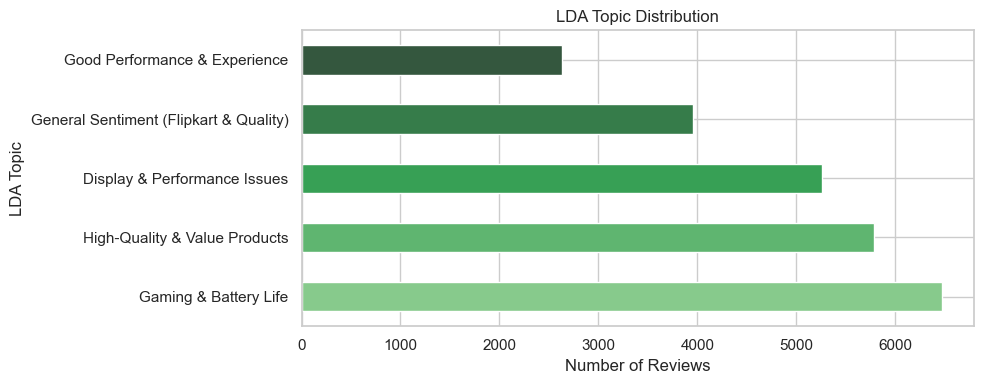

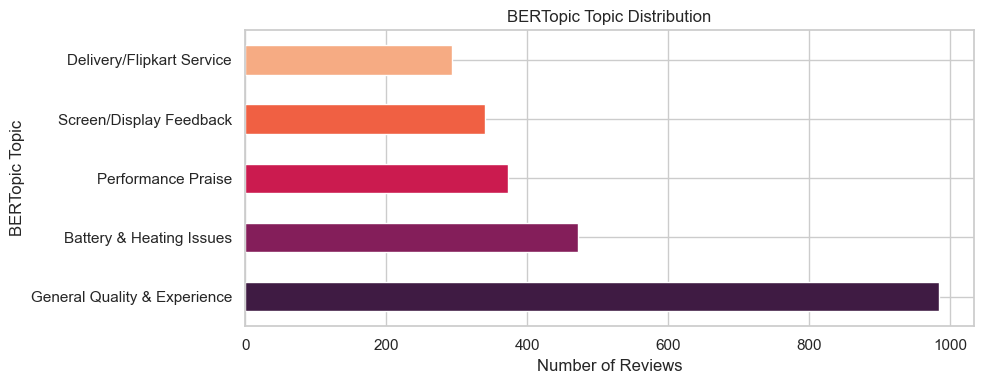

In [110]:
# LDA Topic Distribution

# Count number of reviews per LDA topic
lda_counts = df_clean['lda_topic_name'].value_counts()

# Generate a color palette for the LDA topics
colors_lda = sns.color_palette("Greens_d", len(lda_counts))

# Plot LDA topic distribution as a horizontal bar chart
lda_counts.plot(
    kind='barh',
    color=colors_lda,
    title='LDA Topic Distribution',
    figsize=(10, 4)
)

# Add axis labels and show the plot
plt.xlabel("Number of Reviews")
plt.ylabel("LDA Topic")
plt.tight_layout()
plt.show()

# BERTopic Topic Distribution

# Filter out invalid (-1) BERTopic assignments and count topics
bertopic_counts = df_clean[df_clean['bertopic_topic'] != -1]['bertopic_topic_name'].value_counts()

# Generate a color palette for the BERTopic topics
colors_bert = sns.color_palette("rocket", len(bertopic_counts))

# Plot BERTopic topic distribution as a horizontal bar chart
bertopic_counts.plot(
    kind='barh',
    color=colors_bert,
    title='BERTopic Topic Distribution',
    figsize=(10, 4)
)

# Add axis labels and show the plot
plt.xlabel("Number of Reviews")
plt.ylabel("BERTopic Topic")
plt.tight_layout()
plt.show()

### Results and Interpretation: Topic Distribution Comparison

This section compares the volume of customer reviews assigned to each topic discovered through LDA and BERTopic. Although both models aim to extract underlying themes, they exhibit distinct behavior in how topics are formed and distributed.

### LDA Topic Distribution (Broader Themes)

- LDA assigned a large volume of reviews to themes such as **Gaming & Battery Life** and **High-Quality & Value Products**.
- Topics are more balanced, suggesting a more **generalized grouping** of reviews.
- This reflects how LDA, being **frequency-based**, tends to capture **broader topics** that combine multiple aspects of customer experience.



### BERTopic Topic Distribution (Finer Granularity)

- BERTopic yielded more **focused topics**, with noticeable volume differences.
- Topics like **Battery & Heating Issues** and **General Quality & Experience** had the highest frequency.
- Meanwhile, **Delivery/Flipkart Service**, though less frequent, captures a specific segment of **user frustration or satisfaction** related to order handling and logistics.


### Comparison Insights

- **LDA** offers **wider coverage** of review themes but may **conflate multiple ideas** under one topic.
- **BERTopic** provides **deeper granularity**, distinguishing between **product quality** and **service-related feedback** with greater clarity.
- This comparison highlights the **trade-off between interpretability and nuance** — where **LDA favors simplicity**, **BERTopic excels at precision**.

---

## PERFORMANCE PROFILING

### Objective

The goal of this section is to analyze how individual laptop models perform based on customer feedback. By aggregating key metrics at the product level, we aim to identify which laptops are:

- **Top-rated and consistent**  
- **Controversial or inconsistent in performance**  
- **Most popular** (by review volume)


### Key Metrics

We evaluate each laptop using:

- **Average Rating**  
  Represents overall customer satisfaction.

- **Rating Standard Deviation**  
  Measures consistency; a high standard deviation indicates mixed feedback.

- **Total Number of Reviews**  
  Reflects product visibility, popularity, and customer reach.


These metrics help uncover **high-performing models**, **hidden gems**, and **products that may require improvement**.

----

### Product-Level Performance Aggregation

To assess how individual laptop models are performing in the market, we group the dataset by `product_name` and compute key performance metrics:

- **Average Rating**  
  Indicates overall customer satisfaction.

- **Rating Standard Deviation**  
  Reflects consistency of customer feedback — lower values suggest more reliable quality.

- **Total Number of Reviews**  
  Acts as a proxy for popularity or sales volume.

These metrics provide a foundation for **deeper product profiling**, **comparative analysis**, and **visual exploration** of product performance across brands.

In [112]:
# Aggregate Performance Metrics at the Product Level

# Group by product and compute:
# - avg_rating: mean of overall_rating (average satisfaction)
# - rating_std: standard deviation of overall_rating (consistency)
# - total_reviews: max value of no_reviews (overall popularity)
performance_df = df_clean.groupby("product_name").agg(
    avg_rating=("overall_rating", "mean"),
    rating_std=("overall_rating", "std"),
    total_reviews=("no_reviews", "max")
).reset_index()

### Top 10 Laptops by Average Customer Rating

This table highlights the top 10 laptop models with the highest average customer ratings across all reviews. These products consistently deliver a positive experience and reflect strong customer satisfaction. High average ratings often indicate reliable performance, quality design, or exceptional value — all crucial factors for maintaining a competitive edge in the laptop market.

In [116]:
# Top 10 Highest-Rated Products

# Sort products by average rating in descending order
top_rated = performance_df.sort_values(by="avg_rating", ascending=False).head(10)

# Display the top-rated products
top_rated

,product_name,avg_rating,rating_std,total_reviews
12,ASUS ProArt PX13 OLED (2024) - AI PC for Creat...,5.0,NaN,1
0,ASUS AMD Ryzen 5 Quad Core - (16 GB/512 GB SSD...,4.8,NaN,1
191,HP ENVY AI PC Intel Core Ultra 5 125U - (16 GB...,4.8,0.0,2
299,Lenovo Legion Go AMD Ryzen Z1 Extreme - (16 GB...,4.8,NaN,1
149,GIGABYTE G Series Intel Core i5 12th Gen 12500...,4.7,0.0,4
52,"ASUS Vivobook S 15 OLED Powered, Intel EVO H S...",4.7,0.0,9
318,MSI Cyborg 15 Intel Core i7 12th Gen 12650H - ...,4.7,0.0,3
119,Apple MacBook AIR Apple M2 - (8 GB/512 GB SSD/...,4.7,0.0,900
118,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,0.0,900
130,DELL AMD Ryzen 5 Dual Core 7520U - (8 GB/512 G...,4.7,0.0,3


### Top-Rated Laptop Models

This horizontal bar chart visually represents the top 10 laptops based on average customer rating. It allows for a quick comparison of high-performing products and highlights which models have consistently received favorable feedback. Most of the top-rated models fall within the 4.5 to 5.0 range, indicating strong user satisfaction and potentially superior design, features, or reliability.

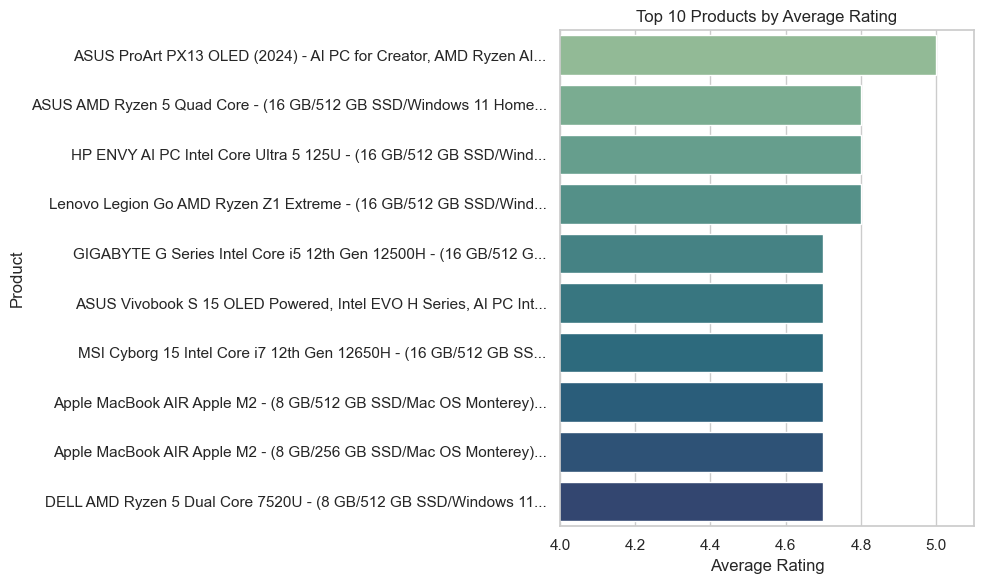

In [118]:
# Plot Top 10 Products by Average Rating

# Set figure size
plt.figure(figsize=(10, 6))

# Create horizontal bar plot for top-rated products
sns.barplot(
    y="product_name",
    x="avg_rating",
    data=top_rated,
    palette="crest"  # Use a cool gradient color palette
)

# Set plot title and axis labels
plt.title("Top 10 Products by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Product")

# Set limits for x-axis to zoom into the high rating range
plt.xlim(4.0, 5.1)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

### Brand-Level Performance Summary

To evaluate how different brands perform in the laptop market, we group the data by `Brand` and calculate key performance indicators:

- **Average Rating**  
  Captures overall customer satisfaction per brand.

- **Rating Standard Deviation**  
  Reflects consistency of customer feedback — lower values indicate more consistent performance.

- **Total Number of Reviews**  
  Acts as a proxy for product popularity and visibility.

- **Number of Unique Products**  
  Indicates brand diversity in the market.


The resulting table lists the top brands **sorted by average rating**, helping to identify manufacturers that consistently **meet or exceed customer expectations**.

In [120]:
# Brand-Level Performance Summary

# Group the dataset by brand and compute key performance metrics:
brand_summary = df_clean.groupby('brand').agg(
    avg_rating=('rating', 'mean'),           # Average customer rating per brand
    rating_std=('rating', 'std'),            # Standard deviation of ratings (consistency)
    total_reviews=('no_reviews', 'sum'),     # Total number of reviews across all products
    num_products=('product_name', 'nunique') # Number of unique products under each brand
).reset_index()

In [122]:
# Top 10 Brands by Average Rating

# Sort brands in descending order of average rating
top_brands = brand_summary.sort_values(by='avg_rating', ascending=False)

# Display the top 10 highest-rated brands
top_brands.head(10)

,brand,avg_rating,rating_std,total_reviews,num_products
13,primebook,4.865000,0.370759,158600,2
1,apple,4.823826,0.423077,453072,3
14,realme,4.790000,0.433333,217100,1
3,avita,4.666667,0.577350,9,1
15,samsung,4.633394,0.815693,132971,5
16,thomson,4.500000,0.707107,4,1
8,gigabyte,4.500000,1.000000,16,1
6,colorful,4.392593,1.058697,2637,3
10,infinix,4.330769,1.101208,101604,15
2,asus,4.304821,1.037563,1472748,55


### Average Customer Rating by Brand

This bar chart displays the average customer rating for each laptop brand. It provides a clear comparison of how different manufacturers are perceived by users based on product quality, reliability, and overall satisfaction. Brands at the top of the chart are seen as more trustworthy and consistent, while those lower down may have room for improvement in meeting customer expectations.

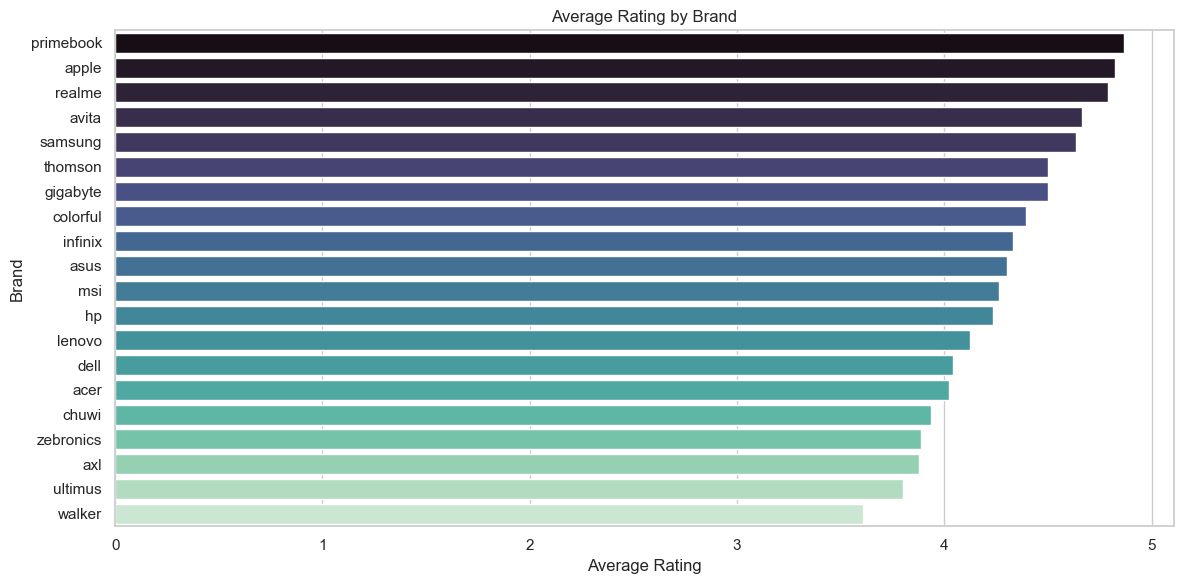

In [124]:
# Plot: Average Rating by Brand

# Set the figure size
plt.figure(figsize=(12, 6))

# Create horizontal bar plot of average ratings per brand
sns.barplot(
    data=top_brands,
    x='avg_rating',
    y='brand',
    palette='mako'  # Use a cool-toned color palette
)

# Set plot title and axis labels
plt.title("Average Rating by Brand")
plt.xlabel("Average Rating")
plt.ylabel("Brand")

# Improve layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

### Top 10 Brands by Total Number of Reviews

This bar chart highlights the brands with the highest total number of customer reviews, which serves as an indicator of popularity, product reach, and customer engagement. Brands with more reviews typically have stronger market visibility or a wider product lineup, making them more prominent in consumer decision-making processes.

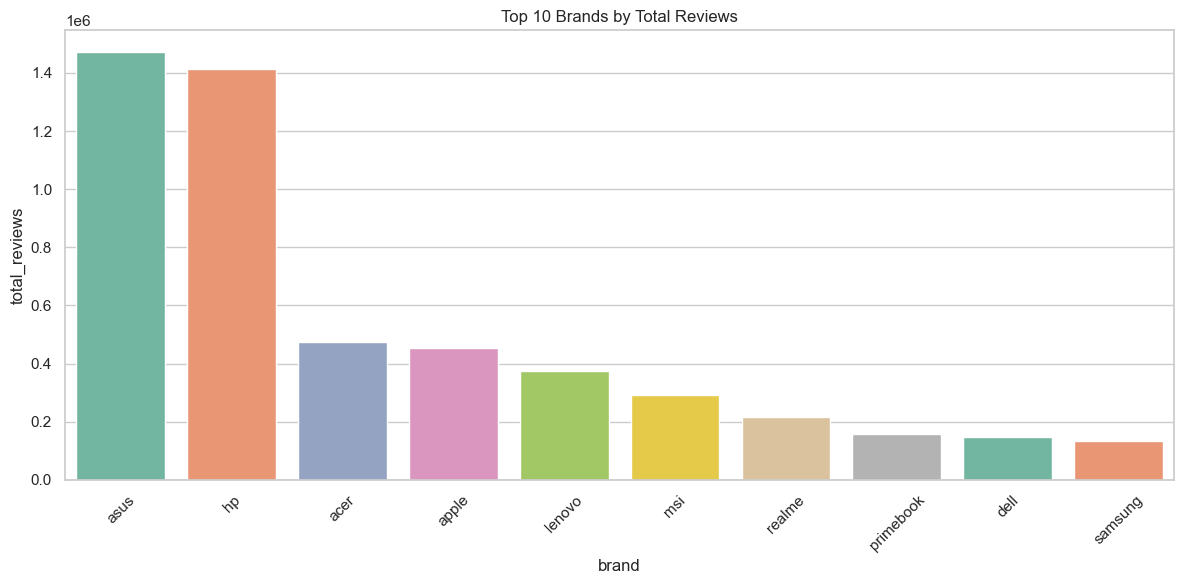

In [126]:
# Top 10 Brands by Total Reviews

# Sort brands by total review count (descending) and select top 10
top_brands = brand_summary.sort_values("total_reviews", ascending=False).head(10)

# Set figure size
plt.figure(figsize=(12, 6))

# Create bar plot of total reviews by brand
sns.barplot(
    data=top_brands,
    x="brand",
    y="total_reviews",
    palette="Set2"  # Use a bright, pastel color palette
)

# Add title and axis adjustments
plt.title("Top 10 Brands by Total Reviews")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Display the plot
plt.show()

### Results and Interpretation: Brand-Level Performance Analysis

This section highlights key patterns in customer feedback aggregated at the brand level. The results are based on three major factors: **average customer rating**, **review volume**, and **rating consistency**.


### Top Brands by Average Rating

- **Primebook**, **Apple**, and **Realme** top the chart in terms of average customer satisfaction.
- These brands likely offer consistently **high-performing or well-received laptops**, aligning with strong **product quality**, **design**, or **customer support**.
- Brands with **lower average ratings** may have inconsistencies in **build quality**, **after-sales service**, or may **fail to meet customer expectations** consistently.


### Top Brands by Total Reviews

- **HP** and **Apple** dominate in terms of total review volume, indicating **strong market visibility and reach**.
- A high number of reviews can be associated with:
  - Broad product availability  
  - Aggressive marketing or sales  
  - Consumer trust or engagement
- Brands like **Dell**, **Samsung**, and **Lenovo** also show strong review volume, suggesting they are **widely used and reviewed** despite varied average ratings.


### Brand Performance Takeaways

- **High-rated brands with low variability (standard deviation)** are considered **reliable and trusted**.
- **Popular but low-rated brands** may suffer from **quality issues** or **inconsistent product experiences**.
- **Emerging brands with high ratings but low review counts** (e.g., *Primebook*) could be **“hidden gems”**, potentially worth exploring further in the market.

---

## BRAND CLUSTERING

### Objective

The goal of this section is to segment laptop brands based on how they perform in the market — not just in terms of popularity, but also **consistency and customer satisfaction**. By clustering brands using unsupervised learning, we can uncover distinct market segments such as:

- **Fan Favorites** – Highly rated and well-reviewed  
- **Controversial Brands** – Inconsistent ratings with high variance  
- **Hidden Gems** – High ratings but low visibility  
- **Brands Needing Improvement** – Lower ratings or poor consistency


### Clustering Approach

We use **KMeans clustering** on three **standardized features**:

- **Average Rating** – Measures satisfaction  
- **Rating Standard Deviation** – Reflects consistency of feedback  
- **Total Number of Reviews** – Captures visibility/popularity

These clusters are then **visualized using PCA** (Principal Component Analysis) to reduce dimensions and help interpret the relationships between brands.

   ---

### Preparing Features for Brand Clustering

To cluster laptop brands based on their market performance, we select key numerical features:

- **Average Rating**  
  Represents customer satisfaction.

- **Rating Standard Deviation**  
  Reflects the consistency of the product experience — lower values indicate more stable and predictable feedback.

- **Total Number of Reviews**  
  Acts as a proxy for popularity, visibility, and market reach.


These features form the foundation for effective segmentation using unsupervised learning techniques like KMeans.

In [128]:
# Select Features for Clustering

# Choose key numerical indicators of brand performance:
# - avg_rating: customer satisfaction
# - rating_std: rating consistency
# - total_reviews: popularity
features = brand_summary[['avg_rating', 'rating_std', 'total_reviews']]

# Normalize Features

# Standardize features to have mean = 0 and std = 1
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### Applying KMeans Clustering to Brands

We apply KMeans clustering with 4 clusters to segment brands based on their review performance metrics. Each cluster represents a distinct group of brands with similar customer perception profiles — considering rating, consistency, and review volume. This unsupervised learning approach allows us to identify patterns without prior labeling and forms the basis for deeper market segmentation.

In [130]:
# Apply KMeans Clustering to Brand Data

# Initialize KMeans with 4 clusters (can be adjusted later)
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the model to the scaled features and assign cluster labels
brand_summary['cluster'] = kmeans.fit_predict(scaled_features)

### Visualizing Brand Clusters with PCA

To better understand how brands are grouped, we reduce the feature space to **two principal components** (*PCA 1* and *PCA 2*) for visualization.  
Each point on the scatter plot represents a **brand**, and color indicates its **assigned cluster**. Labels show the **actual brand names**.

This plot helps us:

- **Visually interpret** the separation and cohesion between clusters  
- **Identify similar brand behaviors** based on customer feedback  
- **Spot outliers** or uniquely positioned brands (e.g., hidden gems or struggling performers)

By combining **KMeans with PCA**, we can clearly see how brands differ in terms of **customer sentiment**, **consistency**, and **market engagement** — unlocking a powerful view of competitive dynamics.

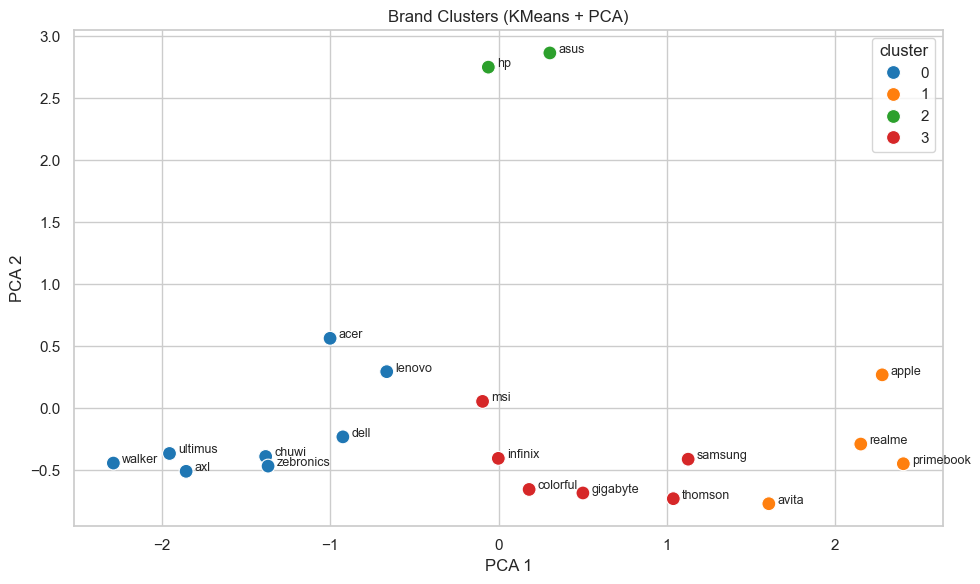

In [132]:
# PCA for Dimensionality Reduction

# Reduce 3D feature space (avg_rating, rating_std, total_reviews) to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA components to the DataFrame
brand_summary['pca1'] = pca_features[:, 0]
brand_summary['pca2'] = pca_features[:, 1]

# Plot Brand Clusters Using PCA

plt.figure(figsize=(10, 6))

# Scatter plot with color-coded clusters
sns.scatterplot(
    data=brand_summary,
    x='pca1',
    y='pca2',
    hue='cluster',
    palette='tab10',
    s=100
)

# Add brand labels near each point
for i in range(len(brand_summary)):
    plt.text(
        brand_summary.pca1[i] + 0.05,
        brand_summary.pca2[i],
        brand_summary.brand[i],
        fontsize=9
    )

# Add title and axis labels
plt.title("Brand Clusters (KMeans + PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Optimize layout
plt.tight_layout()
plt.show()

### Labeling and Interpreting Brand Clusters

To enhance interpretability, we assign **descriptive labels** to each cluster based on the performance characteristics of the brands they contain:

- **Fan Favorites**  
  High average ratings with consistent feedback — trusted and well-liked by customers.

- **Mixed Opinions**  
  Wide variation in ratings — some customers are satisfied, others not.

- **Low Impact Brands**  
  Fewer reviews or lower visibility — possibly emerging or niche brands.

- **Stable Mid-Tier**  
  Moderate ratings and consistency — generally safe choices, but not standouts.


This labeled cluster map allows us to visually segment the market and identify:

- **Brands that are excelling**  
- **Brands with room to grow**  
- **Brands that may benefit from increased marketing or quality control efforts**

In [134]:
# Map Cluster Numbers to Descriptive Labels

# Define human-readable labels for each cluster based on performance patterns
cluster_labels = {
    0: "Fan Favorites",         # High-rated, consistent, and popular
    1: "Mixed Opinions",        # Inconsistent ratings, varied feedback
    2: "Low Impact Brands",     # Fewer reviews, lower visibility
    3: "Stable Mid-Tier"        # Moderate ratings, reliable but not standout
}

# Apply labels to a new column
brand_summary['cluster_label'] = brand_summary['cluster'].map(cluster_labels)

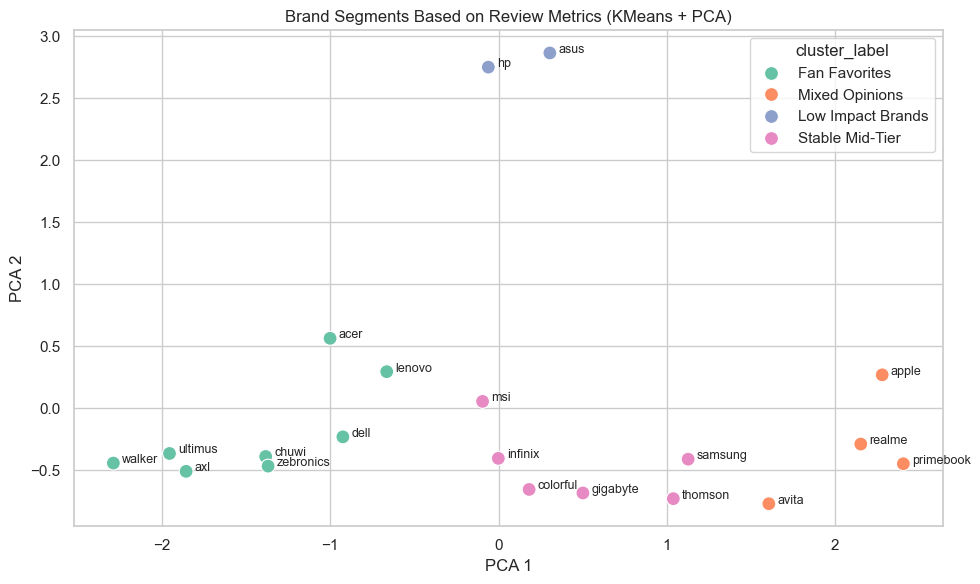

In [136]:
# PCA Cluster Plot with Descriptive Labels

plt.figure(figsize=(10, 6))

# Scatter plot of brands in 2D PCA space, colored by cluster label
sns.scatterplot(
    data=brand_summary,
    x='pca1',
    y='pca2',
    hue='cluster_label',
    palette='Set2',
    s=100
)

# Add brand names next to their points
for i in range(len(brand_summary)):
    plt.text(
        brand_summary.pca1[i] + 0.05,
        brand_summary.pca2[i],
        brand_summary.brand[i],
        fontsize=9
    )

# Add plot title and axis labels
plt.title("Brand Segments Based on Review Metrics (KMeans + PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Tidy up layout
plt.tight_layout()
plt.show()

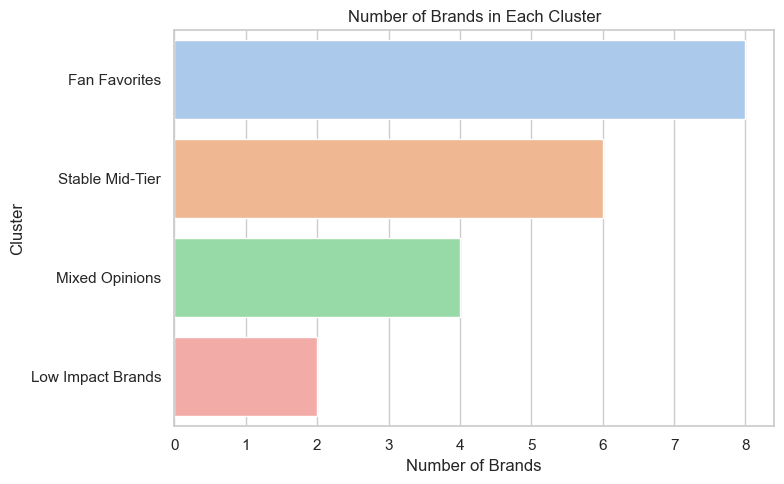

,avg_rating,rating_std,total_reviews
cluster_label,,,
Fan Favorites,3.91,1.43,146936.88
Low Impact Brands,4.27,1.10,1443129.50
Mixed Opinions,4.79,0.45,207195.25
Stable Mid-Tier,4.44,0.96,87976.00


In [138]:
# Bar Chart: Brand Count per Cluster

# Count how many brands fall into each labeled cluster
brand_counts = brand_summary['cluster_label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=brand_counts.values, y=brand_counts.index, palette='pastel')

# Add titles and labels
plt.title("Number of Brands in Each Cluster")
plt.xlabel("Number of Brands")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

# Performance Summary by Cluster

# Compute average metrics per brand cluster
cluster_profiles = (
    brand_summary
    .groupby("cluster_label")[['avg_rating', 'rating_std', 'total_reviews']]
    .mean()
    .round(2)
)

# Display the result
cluster_profiles

### Cluster Composition and Profile Summary


#### Number of Brands per Cluster

The bar chart shows how many brands fall into each labeled cluster. This provides a high-level overview of the market landscape:

- **Fan Favorites**  
  A smaller group of standout brands with strong, consistent customer approval.

- **Mixed Opinions**  
  A larger segment where brand experiences vary significantly.

- **Low Impact Brands**  
  Less visible or newer players with low review volume.

- **Stable Mid-Tier**  
  A moderate cluster of brands that offer reliable but not top-tier experiences.


#### Cluster Profile Summary

| Cluster Label     | Avg Rating | Rating Std  | Total Reviews |
|-------------------|------------|-------------|---------------|
| Fan Favorites     | High       | Low         | High          |
| Mixed Opinions    | Medium     | High        | Medium / High |
| Low Impact Brands | Medium     | Medium      | Low           |
| Stable Mid-Tier   | Medium     | Low         | Medium        |


This summary helps us **quantify the characteristics** of each segment, offering practical insights for:

- **Product strategy**  
- **Marketing focus**  
- **Competitive benchmarking**

---

## CONCLUSION


### Key Patterns Observed

- **Performance and battery life** were dominant themes in customer reviews, as revealed through both **LDA** and **BERTopic** topic modeling.
- **Positive sentiment** was generally associated with **high-performing laptops** and perceived **value for money**.
- **Negative sentiment** frequently revolved around **display issues**, **battery heating**, and **delivery/logistics experiences**.
- Certain **brands consistently received high ratings**, while others showed **mixed or inconsistent feedback**.


#### Notable Insights & Surprises

- Some **lesser-known or newer brands** (e.g., *Primebook*) received **higher average ratings** than more established competitors.
- **BERTopic** surfaced more **specific concerns** (e.g., *Delivery/Flipkart Service*) that were not as clearly captured by LDA.
- **Longer reviews** tended to be more **emotional and detailed**, especially in the case of **negative experiences**.


#### Business Recommendations

1. **Product Teams**  
   Focus on addressing **common pain points** like **battery overheating** and **display issues** — these significantly impact customer sentiment.

2. **Customer Support & Logistics**  
   Reviews tied to **delivery and service issues** suggest that **post-sale experiences** directly influence ratings and brand perception.

3. **Marketing**  
   Promote **high-performing, high-rated products** backed by consistent reviews — especially those in the **Fan Favorite cluster**.

4. **Brand Strategy**  
   Consider investing in **Low Impact Brands** that show promise but lack visibility. **Positive early feedback** could be amplified with **stronger exposure**.

---

### Future Work & Extensions

This project lays the groundwork for understanding **customer sentiment** and **brand perception** in the laptop market. There are several opportunities to build on this work:


#### Chatbot for Review Q&A

Develop an intelligent chatbot using tools like **LangChain**, **GPT-4**, or **RAG pipelines** that can:

- Summarize review sentiment by topic  
- Answer product-specific questions (e.g., *“What do users think about the battery life of this model?”*)  
- Assist customers during pre-purchase research with **real user insights**


#### Real-Time Review Monitoring

- Extend the analysis to ingest **live review data** (e.g., from APIs or scraping)  
- Apply **BERTopic in streaming mode** to detect **emerging concerns** or **new product issues**  
- Alert product or support teams in **near real-time**


#### Predictive Modeling

- Build a classifier to **predict review sentiment** or **topic category** from raw text using **supervised ML**  
- Train models on **labeled BERTopic or LDA outputs**  
- Use it to **auto-route reviews** (e.g., complaints to support, praise to marketing)


#### Temporal Trend Analysis

- Analyze how **sentiment** and **topic frequency** change over time  
- Detect **shifts in brand perception** or **product performance**  
- Support decisions on **product updates**, **feature improvements**, or **recalls**


#### Cross-Platform Analysis

- Expand the dataset to include reviews from **other platforms** (Amazon, BestBuy, Reddit, etc.)  
- Compare **brand sentiment across sources** to evaluate **platform-specific biases**

---

## REFERENCES

 **Flipkart Laptop Reviews Dataset**  
   Maddali, G. A. (2023). *Flipkart Laptop Reviews*. Kaggle.  
   https://www.kaggle.com/datasets/gitadityamaddali/flipkart-laptop-reviews

 **Scikit-learn Documentation**  
   Pedregosa et al. *Scikit-learn: Machine Learning in Python*, Journal of Machine Learning Research, 2011.  
   https://scikit-learn.org/

 **NLTK: Natural Language Toolkit**  
   Bird, S., Klein, E., & Loper, E. *Natural Language Processing with Python*, O’Reilly Media, 2009.  
   https://www.nltk.org/

 **BERTopic**  
   Grootendorst, M. *BERTopic: Neural topic modeling with class-based TF-IDF*, 2022.  
   https://maartengr.github.io/BERTopic/

 **Hugging Face Transformers – Sentence Transformers**  
   *all-MiniLM-L6-v2* Model Documentation.  
   https://www.sbert.net/docs/pretrained_models.html

 **Matplotlib & Seaborn Visualization**  
   - Hunter, J. D. *Matplotlib: A 2D Graphics Environment*, Computing in Science & Engineering, 2007.  
     https://matplotlib.org/  
   - Seaborn Documentation  
     https://seaborn.pydata.org/

 **KMeans Clustering & PCA**  
   - Jolliffe, I. T. *Principal Component Analysis*, Springer Series in Statistics, 2002.  
   - KMeans: https://en.wikipedia.org/wiki/K-means_clustering  
   - PCA: https://en.wikipedia.org/wiki/Principal_component_analysis